In [3]:
from loveisland.common.functions import Functions as F
from loveisland.common.constants import ISLANDERS, RESULTS

import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import re
import pandas as pd
import os

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [4]:
ISLANDERS = {k: v for k, v in ISLANDERS.items() if v["season"] == 4}

RESULTS_RECODE = {}
for k0, v0 in RESULTS.items():
    RESULTS_RECODE[k0] = {}
    for k1, v1 in RESULTS[k0].items():
        RESULTS_RECODE[k0][k1[0] + "_" + k1[1]] = v1

In [11]:
res = pd.DataFrame.from_dict(RESULTS_RECODE).reset_index()

res = pd.melt(res, id_vars=["index"], value_vars=["2018-06-26", 
"2018-07-04", "2018-07-13", "2018-07-20","2018-07-24","2018-07-29"])

res = res.rename(columns={"variable": "vote", "value": "v_share", "index": "couple"})
res["couple"] = res["couple"].str.lower()
res["v_max"] = res.groupby(["couple", "vote"])["v_share"].transform(max)
res = res[res["v_max"] == res["v_share"]].drop(columns=["v_max"]).reset_index(drop=True)

In [12]:
class Arguments():
    bucket = "../data/"
    season = 4
    
args = Arguments()

In [24]:
class FormatData:
    def __init__(self, args):
        self.args = args
        self.comb = []
        self.agg_df = pd.DataFrame()
        
        self.df = self.recode_dt(F.import_all(
            os.path.join(args.bucket, "season_" + str(args.season), "processed/")
        ))
    
    @staticmethod
    def recode_dt(df, d_col="date"):    
        df["vote"] = np.where(df[d_col] < "2018-06-26", "2018-06-26", "else")
        df["vote"] = np.where(("2018-06-26" <= df[d_col]) & (df[d_col] < "2018-07-04"), "2018-07-04", df["vote"])
        df["vote"] = np.where(("2018-07-04" <= df[d_col]) & (df[d_col] < "2018-07-13"), "2018-07-13", df["vote"])
        df["vote"] = np.where(("2018-07-13" <= df[d_col]) & (df[d_col] < "2018-07-20"), "2018-07-20", df["vote"])
        df["vote"] = np.where(("2018-07-20" <= df[d_col]) & (df[d_col] < "2018-07-24"), "2018-07-24", df["vote"])
        df["vote"] = np.where(("2018-07-24" <= df[d_col]) & (df[d_col] < "2018-07-29"), "2018-07-29", df["vote"])
        return df

    @staticmethod
    def format_pair(pair):
        pair = [i.lower() for i in pair]
        return pair, pair[0] + "_" + pair[1]

    def do_agg(self, ph, gb=["vote"]):
        """Aggregate various metrics per couple/date"""
        AGG_JS = {
            "favs": "mean",
            "retwe": "mean",
            "score": "mean",
            "user": "nunique",
            "url": "count",
            "weight_senti": "mean",
        }
        RN_JS = {"url": "n_tweets", "user": "n_users"}

        df = self.df[self.df["score"] != 0]
        if ph is not None:
            df = df[df[ph] == ph]
            gb = gb + [ph]
            RN_JS[ph] = "couple"
        if len(df) > 0:
            return df.groupby(gb).agg(AGG_JS).reset_index().rename(columns=RN_JS)
        return pd.DataFrame()

    def get_couples(self):
        [self.comb.extend(list(v.keys())) for k, v in RESULTS.items()]
        self.comb = list(set(self.comb))
        return self

    def get_totals(self):
        return self.do_agg(None)[["vote", "n_tweets", "n_users"]].rename(
            columns={"n_tweets": "n_tweets_total", "n_users": "n_users_total"}
        )

    def get_perc(self, col):
        self.agg_df[col + "_perc"] = self.agg_df[col] * 100 / self.agg_df[col + "_total"]
        return self

    def get_agg_df(self):
        self.get_couples()

        for pair in self.comb:
            pair, ph = self.format_pair(pair)
            if pair[0] in self.df.columns and pair[1] in self.df.columns:
                self.df[ph] = np.where(
                    (self.df[pair[0]] == pair[0]) & (self.df[pair[1]] == pair[1]),
                    ph,
                    "nan",
                )

                self.agg_df = self.agg_df.append(
                    self.do_agg(ph), sort=True
                ).reset_index(drop=True)

        self.agg_df = self.agg_df.merge(self.get_totals(), on="vote", how="left")
        self.get_perc("n_tweets")
        self.get_perc("n_users")
        return self

    @staticmethod
    def get_split(x, n):
        return x.split("_")[n]

    def add_islanders(self):
        self.agg_df["female"] = self.agg_df["couple"].apply(
            lambda x: self.get_split(x, 0)
        )
        self.agg_df["male"] = self.agg_df["couple"].apply(
            lambda x: self.get_split(x, 1)
        )
        return self


In [50]:
fd = FormatData(args)
fd.get_agg_df().add_islanders()

,couple,favs,n_tweets,n_users,retwe,score,vote,weight_senti,n_tweets_total,n_users_total,n_tweets_perc,n_users_perc,female,male,v_share
0,dani_jack,28.065324,13211,9778,3.448490,0.349394,2018-06-26,8.616272,600637,200233,2.199498,4.883311,dani,jack,71.1
1,dani_jack,33.666474,13855,10053,4.216817,0.153739,2018-07-04,3.253593,311946,120147,4.441474,8.367250,dani,jack,71.9
2,dani_jack,21.821298,4376,3557,2.485832,0.212183,2018-07-13,5.341086,263685,98041,1.659556,3.628074,dani,jack,47.1
3,dani_jack,27.887623,4565,3664,3.104272,0.194115,2018-07-20,3.036385,181262,73067,2.518454,5.014576,dani,jack,50.9
4,dani_jack,32.117663,3646,2959,3.348053,0.050288,2018-07-24,1.568457,59861,31110,6.090777,9.511411,dani,jack,58.4


In [71]:
df = fd.agg_df.merge(res, on=["vote", "couple"], how="left")
df = df[df["n_tweets_perc"] > 1]
df.head()

,couple,favs,n_tweets,n_users,retwe,score,vote,weight_senti,n_tweets_total,n_users_total,n_tweets_perc,n_users_perc,female,male,v_share
0,dani_jack,28.065324,13211,9778,3.448490,0.349394,2018-06-26,8.616272,600637,200233,2.199498,4.883311,dani,jack,71.1
1,dani_jack,33.666474,13855,10053,4.216817,0.153739,2018-07-04,3.253593,311946,120147,4.441474,8.367250,dani,jack,71.9
2,dani_jack,21.821298,4376,3557,2.485832,0.212183,2018-07-13,5.341086,263685,98041,1.659556,3.628074,dani,jack,47.1
3,dani_jack,27.887623,4565,3664,3.104272,0.194115,2018-07-20,3.036385,181262,73067,2.518454,5.014576,dani,jack,50.9
4,dani_jack,32.117663,3646,2959,3.348053,0.050288,2018-07-24,1.568457,59861,31110,6.090777,9.511411,dani,jack,58.4


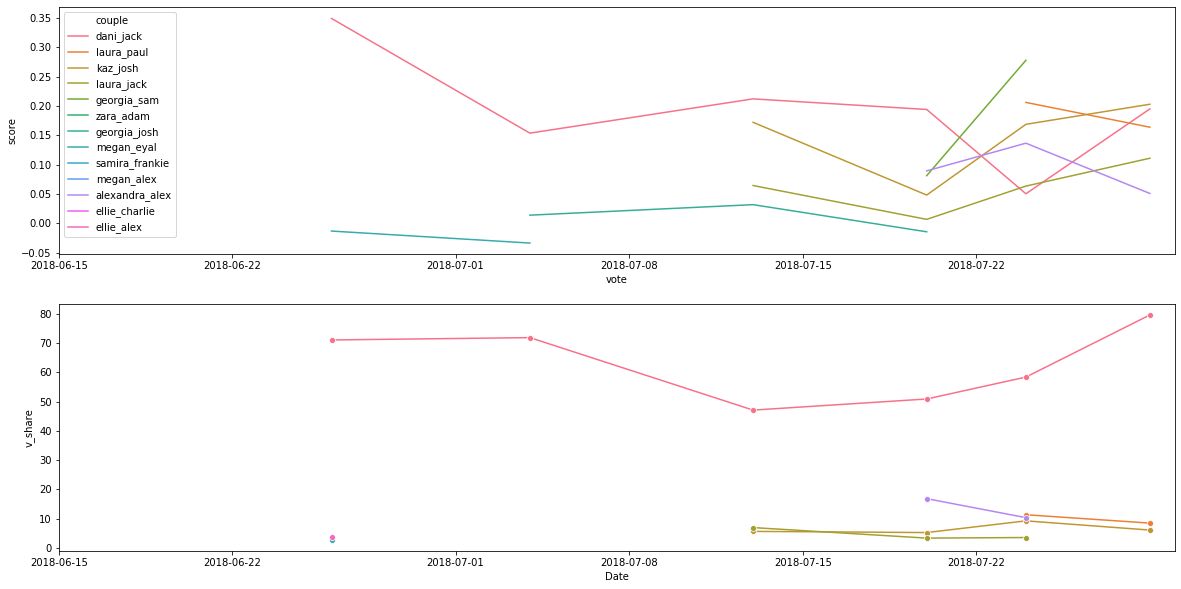

In [72]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharex=ax1)

# sns.lineplot("date", "n_users_perc", "couple", data=df[df["n_tweets"] > 10], ax=ax1)
df = df[df["vote"] != "else"]
df["vote"] = pd.to_datetime(df["vote"])
sns.lineplot("vote", "score", "couple", data=df, ax=ax1)
sns.lineplot("vote", "v_share", "couple", data=df, ax=ax2, marker="o")
ax2.legend().remove()
ax2.set(xlim=("2018-06-15", "2018-07-30"), xlabel="Date");

In [75]:
df["v_share"].corr(df["n_tweets_perc"])

0.555126209532152

In [81]:
df = df[(df["n_tweets_perc"].notna()) & (df["score"].notna()) & (df["v_share"].notna())]

In [85]:
from sklearn import linear_model

reg = linear_model.LinearRegression()
reg.fit(df[['n_tweets_perc', 'score']], df['v_share'])
reg.coef_

array([ 13.52499962, 174.02123466])

In [87]:
n_tweets_perc = 1
score = 0.4

v_share = 13.52499962*n_tweets_perc + 174.02123466*score
v_share

83.13349348400001

(0, 100)

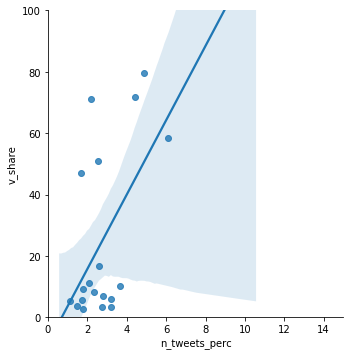

In [76]:
sns.lmplot(x="n_tweets_perc", y="v_share", data=df)
plt.xlim(0,15)
plt.ylim(0, 100)

(0, 100)

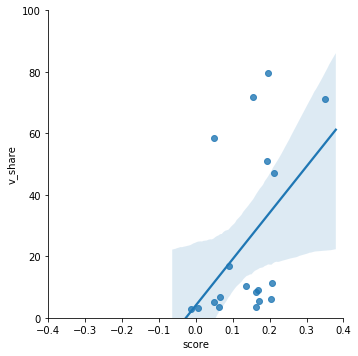

In [79]:
sns.lmplot(x="score", y="v_share", data=df)
plt.xlim(-0.4,0.4)
plt.ylim(0, 100)